# read data and train/test split

In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split

X = pd.read_parquet('../results/X.parquet')
y = pd.read_csv('../results/y.csv')['worse_tomorrow']

print(X.shape, y.shape)

print('label distribution:')
y.value_counts(normalize=True)

(223865, 672) (223865,)
label distribution:


worse_tomorrow
0    0.560972
1    0.439028
Name: proportion, dtype: float64

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier

# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

# standard scaler
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns, index=X_train.index)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns, index=X_test.index)

# train
rf = RandomForestClassifier(n_jobs=-1)
rf.fit(X_train, y_train)

# eval
y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)

print('Test set performance:')
print('Accuracy:', round(acc, 3))
print('ROC AUC:', round(auc, 3))
print()
print('Classification Report:')
print(classification_report(y_test, y_pred))

Test set performance:
Accuracy: 0.627
ROC AUC: 0.66

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.74      0.69     25116
           1       0.59      0.49      0.54     19657

    accuracy                           0.63     44773
   macro avg       0.62      0.61      0.61     44773
weighted avg       0.62      0.63      0.62     44773



<Figure size 640x480 with 0 Axes>

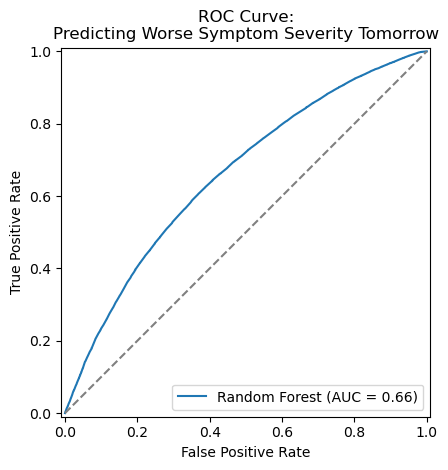

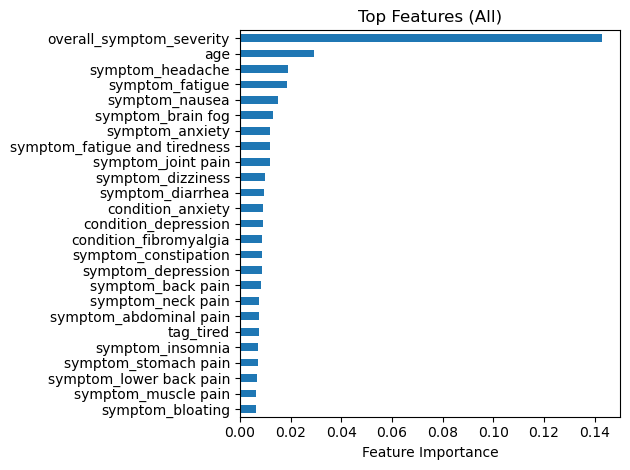

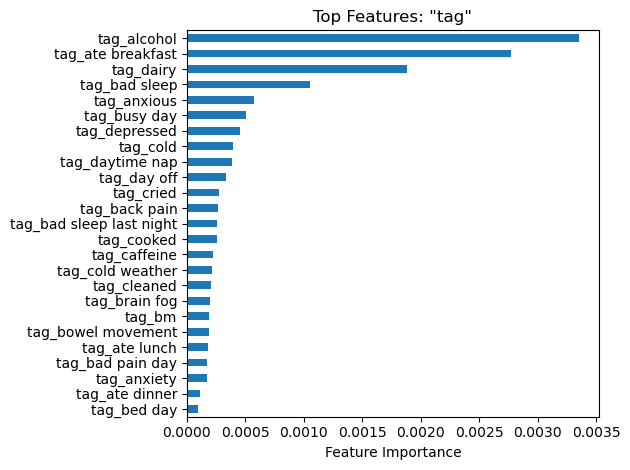

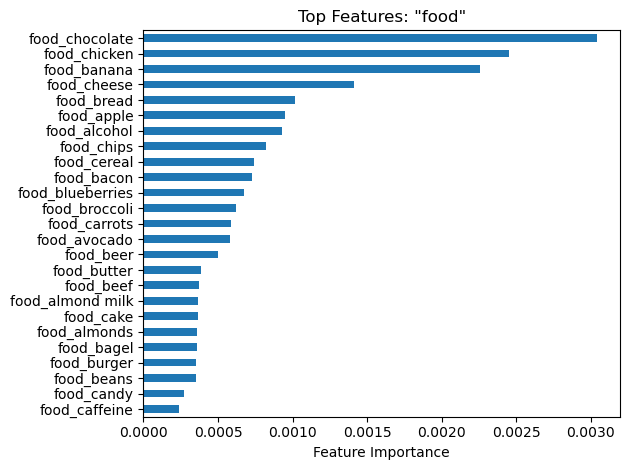

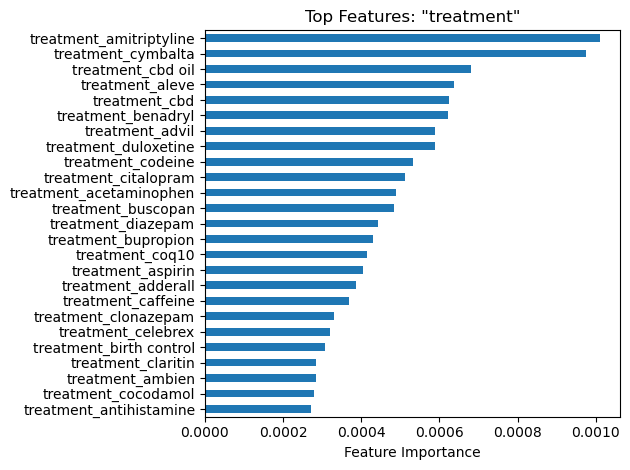

In [15]:
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
import matplotlib.pyplot as plt

# # CM
# plt.figure()
# disp = ConfusionMatrixDisplay.from_estimator(rf, X_test, y_test,
#                                              display_labels=['not worse', 'worse'],
#                                              cmap='Blues')
# plt.title('Random Forest Confusion Matrix')
# plt.tight_layout()
# plt.savefig('../results/cm.png', dpi=300, bbox_inches='tight')

# ROC
plt.figure()
roc_disp = RocCurveDisplay.from_predictions(y_test, y_proba, name='Random Forest')
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.title('ROC Curve:\nPredicting Worse Symptom Severity Tomorrow')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.tight_layout()
plt.savefig('../results/roc.png', dpi=300, bbox_inches='tight')

# FI
TOP_N = 25
plt.figure()
fi = pd.Series(rf.feature_importances_, index=X.columns)
fi_sorted = fi.sort_values(ascending=False)
top_fi = fi_sorted.head(TOP_N).sort_values()
top_fi.plot(kind='barh')
plt.title('Top Features (All)')
plt.xlabel('Feature Importance')
plt.tight_layout()
plt.savefig('../results/fi.png', dpi=300, bbox_inches='tight')

# FI SUBSET
for prefix in ('tag_', 'food_', 'treatment_'):
    plt.figure()
    subset_cols = [c for c in X.columns if c.startswith(prefix)]
    fi_subset = fi[subset_cols]
    top_fi_subset = fi_subset.head(TOP_N).sort_values()
    top_fi_subset.plot(kind='barh')
    plt.title(f'Top Features: "{prefix[:-1]}"')
    plt.xlabel('Feature Importance')
    plt.tight_layout()
    plt.savefig(f'../results/fi_{prefix[:-1]}.png', dpi=300, bbox_inches='tight')

# plot fi as subplots for figure

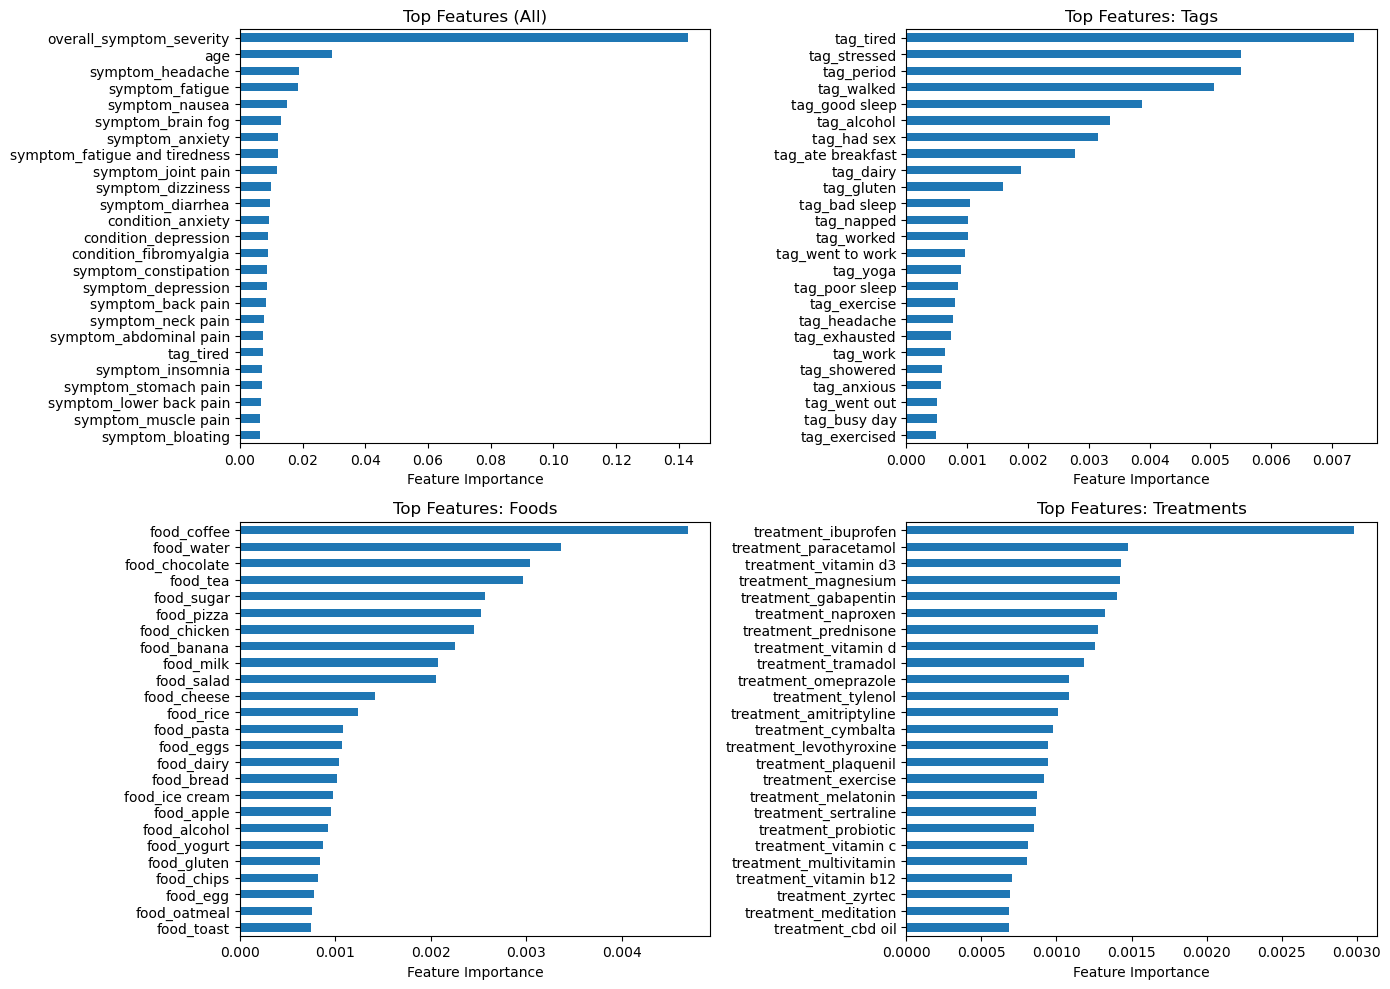

In [20]:
import matplotlib.pyplot as plt
import pandas as pd

TOP_N = 25

# Base feature importance
fi = pd.Series(rf.feature_importances_, index=X.columns)
fi_sorted = fi.sort_values(ascending=False)

# Prepare subsets
prefixes = ["tag_", "food_", "treatment_"]
subset_fi = {
    prefix: fi[[c for c in X.columns if c.startswith(prefix)]]
                .sort_values(ascending=False)
                .head(TOP_N)
    for prefix in prefixes
}

# MAIN PLOT: 1×4 grid
fig, axes = plt.subplots(2,2, figsize=(14, 10))
axes = axes.flatten()

# --- Plot 1: Top Features (All) ---
top_all = fi_sorted.head(TOP_N).sort_values()
top_all.plot(kind='barh', ax=axes[0])
axes[0].set_title("Top Features (All)")
axes[0].set_xlabel("Feature Importance")

# --- Plot 2–4: Prefix categories ---
titles = {
    "tag_": "Top Features: Tags",
    "food_": "Top Features: Foods",
    "treatment_": "Top Features: Treatments",
}

for ax, prefix in zip(axes[1:], prefixes):
    df_plot = subset_fi[prefix].sort_values()
    df_plot.plot(kind="barh", ax=ax)
    ax.set_title(titles[prefix])
    ax.set_xlabel("Feature Importance")

plt.tight_layout()
plt.savefig("../results/fi_subplots.png", dpi=300, bbox_inches="tight")

# not sure about the validity of this... leave out for now

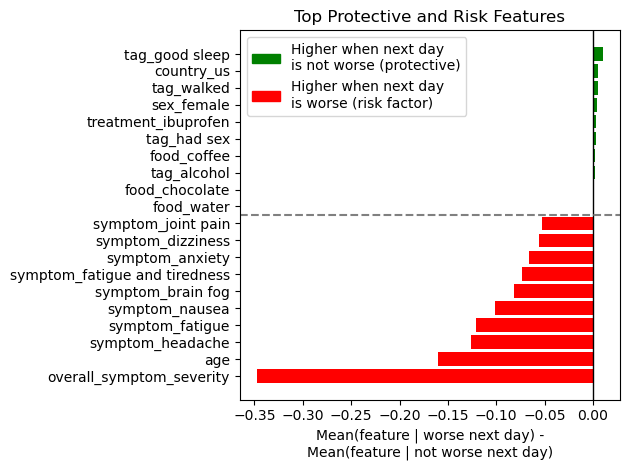

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# protective/risk factor analysis
X_worse = X[y == 1]
mean_worse = X_worse.mean()

X_not_worse = X[y == 0]
mean_not_worse = X_not_worse.mean()

delta = mean_worse - mean_not_worse

# align with fi
delta = delta[fi.index]

# fi_delta df
fi_delta_df = pd.DataFrame({'importance': fi,
                            'delta': delta})

# prot factors
TOP_N = 10
prot_df = fi_delta_df[fi_delta_df['delta'] > 0].copy()
prot_df = prot_df.sort_values('importance', ascending=False).head(TOP_N)
prot_df['effect'] = 'protective'

# risk factors
risk_df = fi_delta_df[fi_delta_df['delta'] < 0].copy()
risk_df = risk_df.sort_values('importance', ascending=False).head(TOP_N)
risk_df['effect'] = 'risk'

# combine and sort by delta
combined = pd.concat([prot_df, risk_df], axis=0)
combined = combined.sort_values('delta')

# plot
plt.figure()
plt.barh(combined.index, combined['delta'], color=combined['effect'].map({'protective': 'green', 'risk': 'red'}))
plt.axvline(0, color='black', linewidth=1) # black line at 0
plt.axhline(TOP_N - 0.5, color='gray', linestyle='--') # separator line
plt.title('Top Protective and Risk Features')
plt.xlabel('Mean(feature | worse next day) -\nMean(feature | not worse next day)')

# Legend
handles = [mpatches.Patch(color='green', label='Higher when next day\nis not worse (protective)'),
           mpatches.Patch(color='red', label='Higher when next day\nis worse (risk factor)')]
plt.legend(handles=handles)

plt.tight_layout()
plt.savefig('../results/fi_prot_risk.png', dpi=300, bbox_inches='tight')